In [10]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)

    for fold in folds:
        fold_path = os.path.join(data_path, fold)
        filelists = os.listdir(fold_path)

        for file in filelists:
            filepaths.append(os.path.join(fold_path, file))
            labels.append(fold)

    # Concatenate data paths with labels
    df = pd.DataFrame({'filepaths': filepaths, 'label': labels})
    return df

train_data_path = 'archive/Training'
train_df = load_data(train_data_path)
test_data_path = 'archive/Testing'
test_df = load_data(test_data_path)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


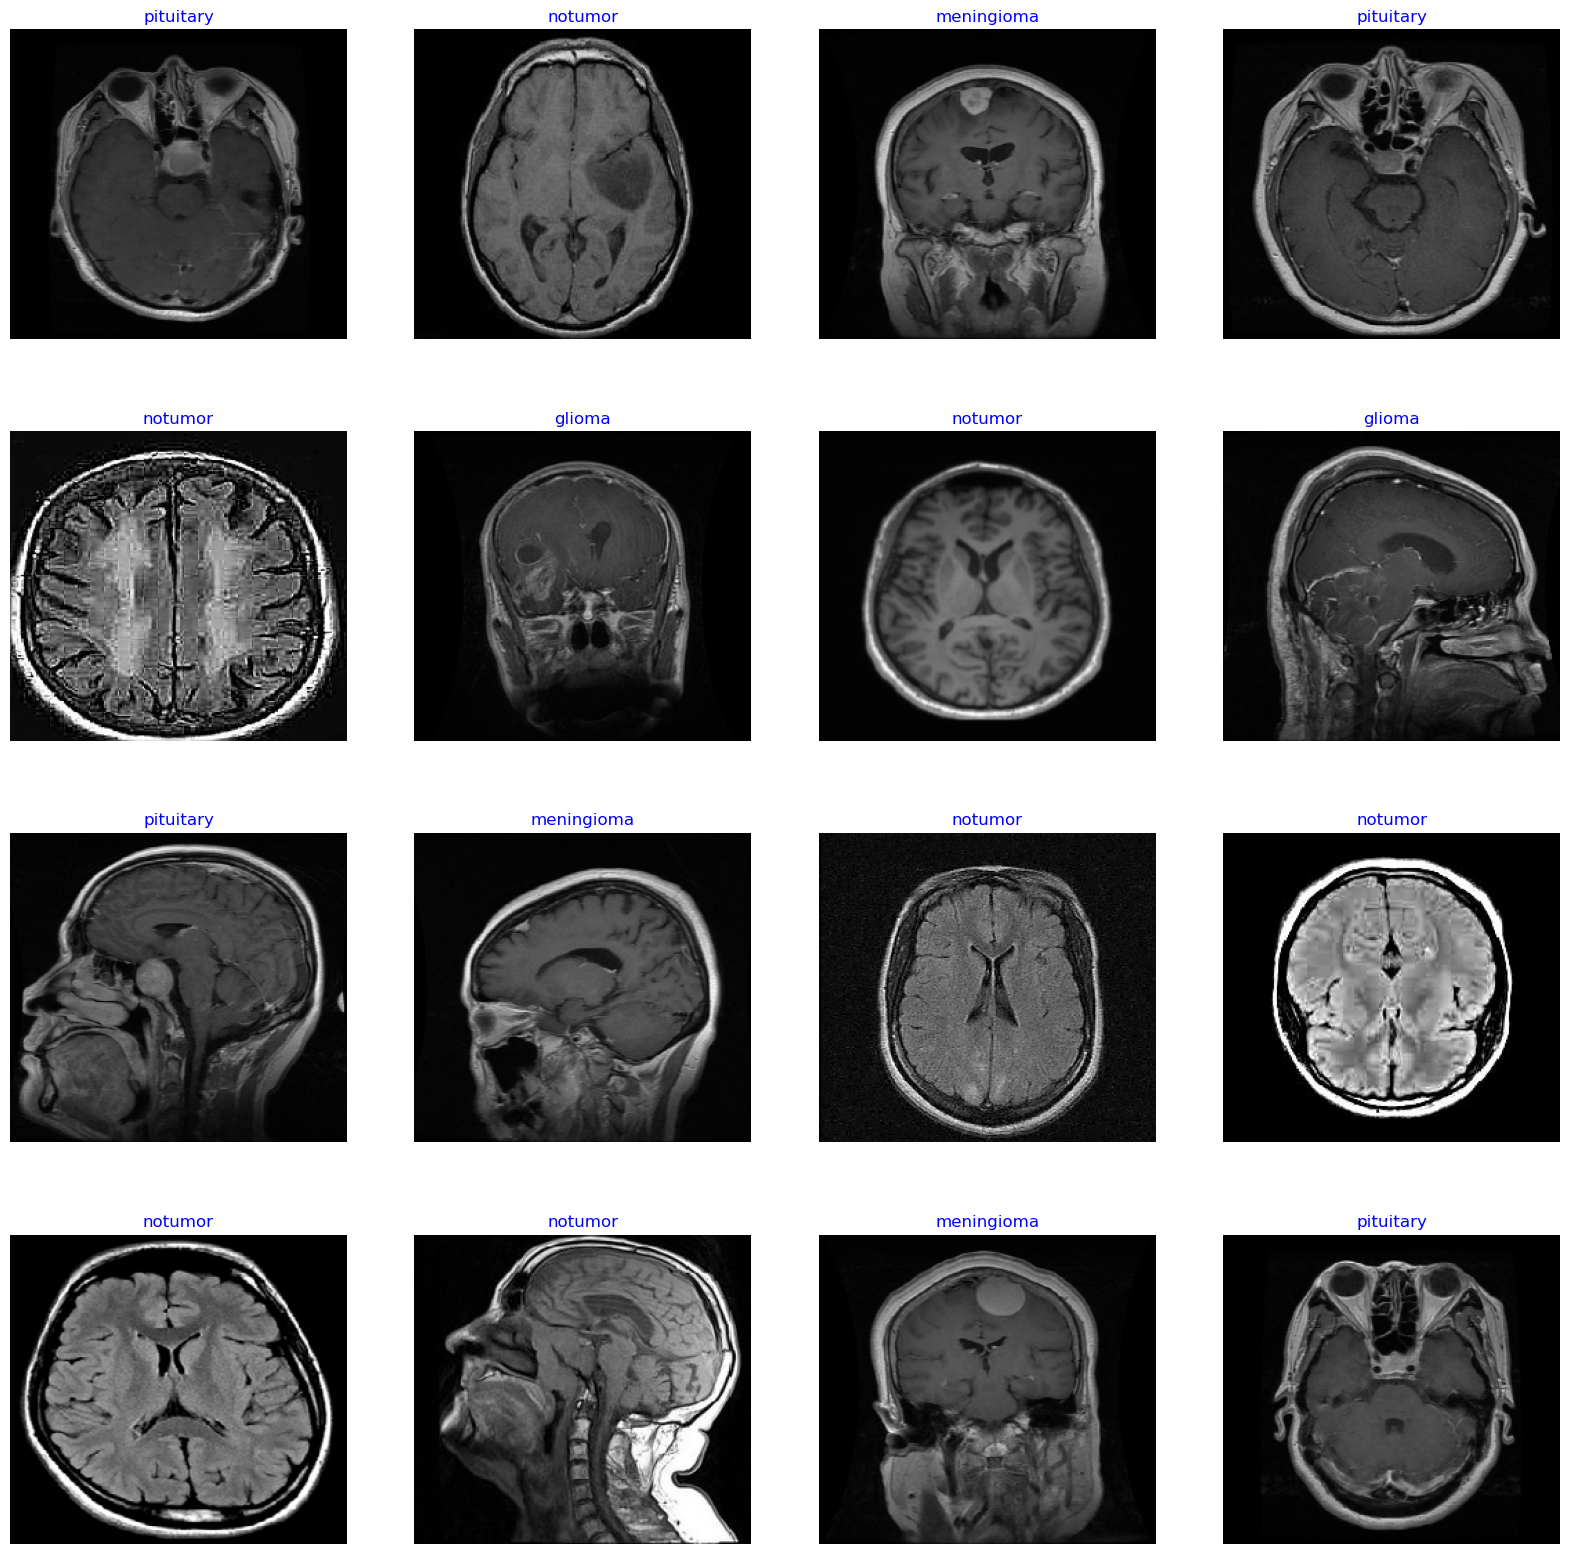

In [4]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)
img_size = (224 ,244)
batch_size = 32

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [6]:
# Create a Sequential model
model = Sequential()

# Convolutional layers
conv_layer_params = [
    (32, (3, 3)),
    (64, (3, 3)),
    (128, (3, 3))
]

for filters, kernel_size in conv_layer_params:
    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(img_size[0], img_size[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Dense (fully connected) layers
dense_layer_params = [
    (256, 'relu', 0.5)
]

for units, activation, dropout_rate in dense_layer_params:
    model.add(Dense(units, activation=activation))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(4, activation='softmax'))  # 4 classes in the output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 121, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 57, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 28, 128)      0

In [7]:
epochs = 10  

history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10


2023-12-10 11:35:31.897192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


179/179 [==============================] - ETA: 0s - loss: 11.5056 - accuracy: 0.7454

2023-12-10 11:39:32.257717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


179/179 [==============================] - 248s 1s/step - loss: 11.5056 - accuracy: 0.7454 - val_loss: 0.5688 - val_accuracy: 0.8153
Epoch 2/10
179/179 [==============================] - 195s 1s/step - loss: 0.3423 - accuracy: 0.8852 - val_loss: 0.3826 - val_accuracy: 0.8672
Epoch 3/10
179/179 [==============================] - 188s 1s/step - loss: 0.2513 - accuracy: 0.9097 - val_loss: 0.2808 - val_accuracy: 0.9053
Epoch 4/10
179/179 [==============================] - 208s 1s/step - loss: 0.1991 - accuracy: 0.9338 - val_loss: 0.2283 - val_accuracy: 0.9206
Epoch 5/10
179/179 [==============================] - 194s 1s/step - loss: 0.1504 - accuracy: 0.9478 - val_loss: 0.2140 - val_accuracy: 0.9282
Epoch 6/10
179/179 [==============================] - 183s 1s/step - loss: 0.1074 - accuracy: 0.9664 - val_loss: 0.1617 - val_accuracy: 0.9359
Epoch 7/10
179/179 [==============================] - 188s 1s/step - loss: 0.0910 - accuracy: 0.9701 - val_loss: 0.1720 - val_accuracy: 0.9374
Epoch 8/1

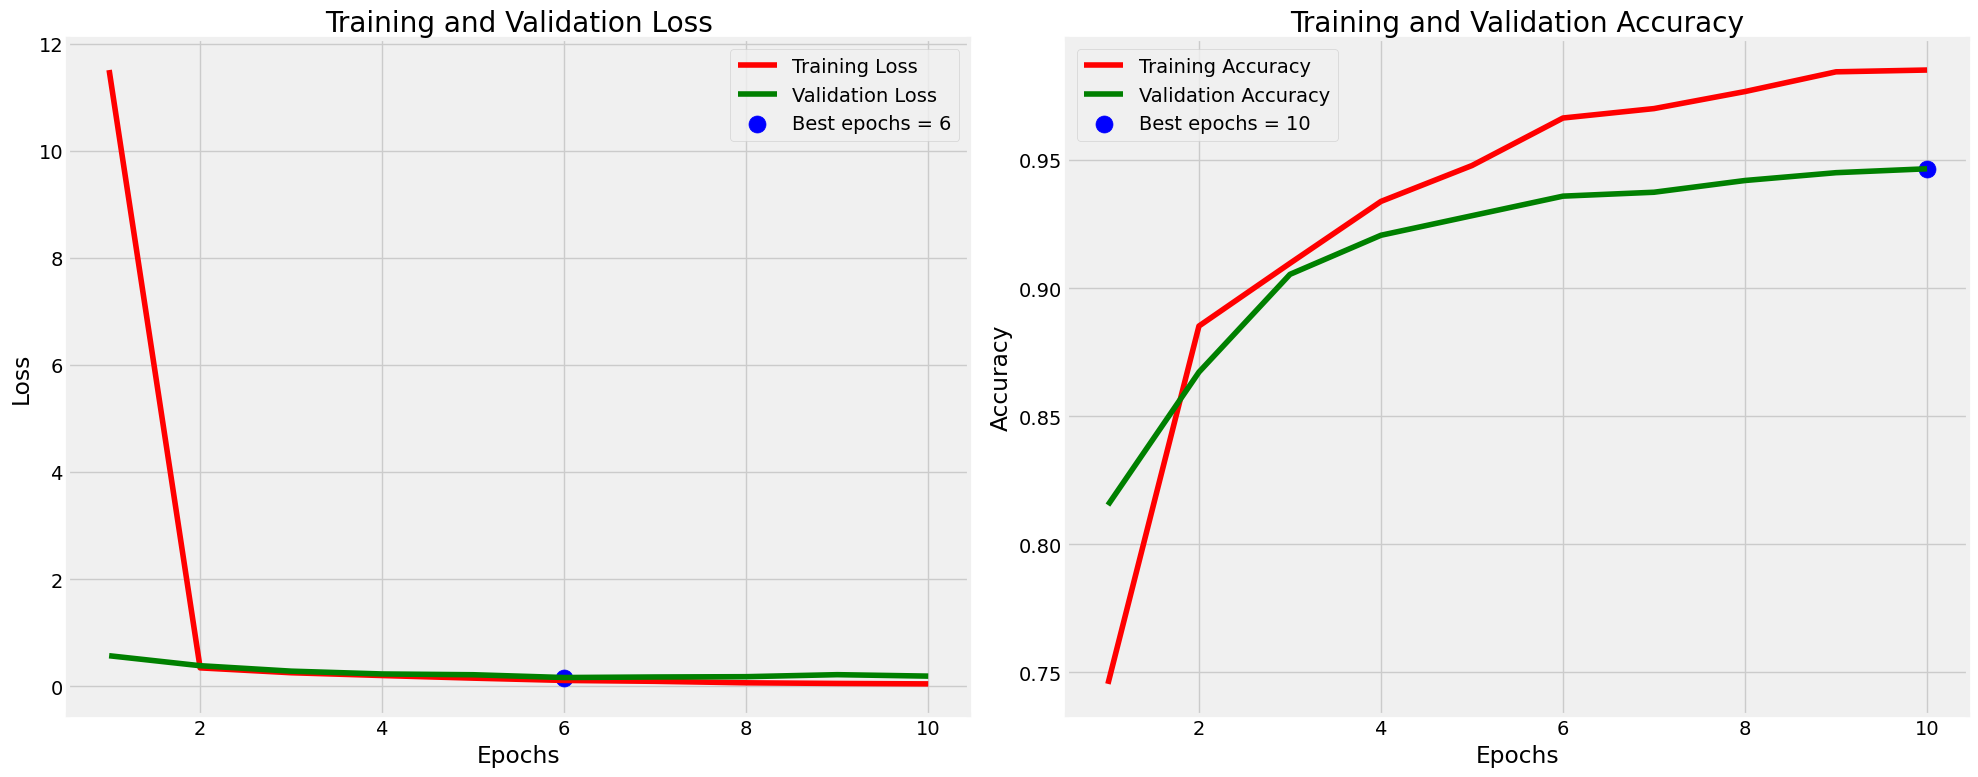

In [8]:
def plot_training_history(history):
    # Extracting metrics from the training history
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Finding the epoch with the lowest validation loss and the highest validation accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    index_acc = np.argmax(val_acc)
    val_highest = val_acc[index_acc]

    # Generating epochs list
    epochs = [i + 1 for i in range(len(train_acc))]

    # Labels for scatter points
    loss_label = f'Best epochs = {str(index_loss + 1)}'
    acc_label = f'Best epochs = {str(index_acc + 1)}'

    # Plotting
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjusting layout and displaying the plot
    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
    return model

def k_fold_cross_validation(data, num_folds=5, epochs=10, batch_size=32):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    for fold_index, (train_indices, valid_indices) in enumerate(skf.split(data['filepaths'], data['label'])):
        print(f"Fold {fold_index + 1}")

        # Create a new model for each fold
        model = create_model()

        # Extract data for this fold
        train_fold_data = data.iloc[train_indices]
        valid_fold_data = data.iloc[valid_indices]

        # Create data generators for this fold with color_mode='rgb'
        train_fold_gen = tr_gen.flow_from_dataframe(train_fold_data, x_col='filepaths', y_col='label', target_size=img_size,
                                                    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

        valid_fold_gen = ts_gen.flow_from_dataframe(valid_fold_data, x_col='filepaths', y_col='label', target_size=img_size,
                                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

        # Train the model
        history = model.fit(train_fold_gen, epochs=epochs, validation_data=valid_fold_gen, verbose=1)

        # Evaluate the model on the test set or do any other desired analysis
        test_results = model.evaluate(test_gen, verbose=0)
        print(f"Test Accuracy for Fold {fold_index + 1}: {test_results[1]}")



combined_data = pd.concat([train_df, valid], ignore_index=True)

# Perform k-fold cross-validation
k_fold_cross_validation(combined_data)

In [19]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

2023-12-10 12:50:44.644272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


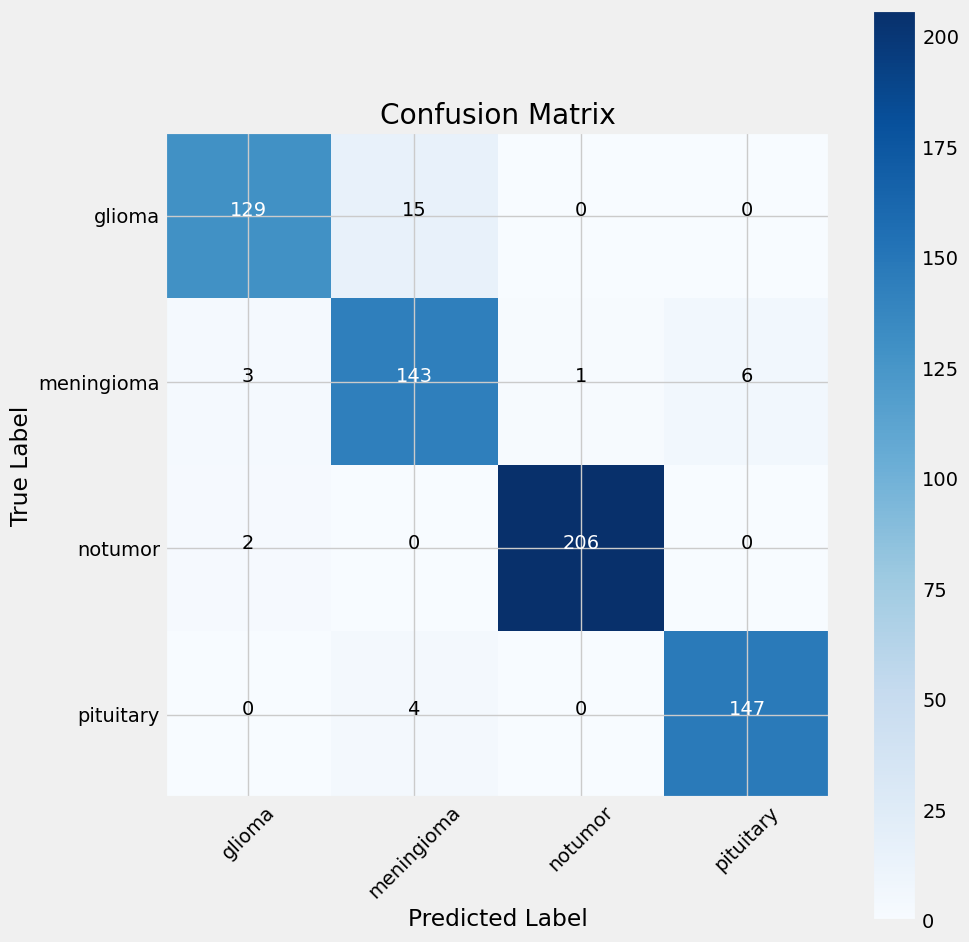

In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [21]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.96      0.90      0.93       144
  meningioma       0.88      0.93      0.91       153
     notumor       1.00      0.99      0.99       208
   pituitary       0.96      0.97      0.97       151

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656



In [22]:
import joblib
joblib.dump(model, 'CNN_model.joblib')

['CNN_model.joblib']